In [303]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling import models, fitting
import numpy 
from scipy import optimize
from matplotlib import pyplot
%matplotlib inline
import aplpy


In [304]:
ROOTfile = "./release_galactic_skymap_fixed_head.fits"
#ROOTfile = "./release_galactic_skymap.fits"
HDUlist = fits.open(ROOTfile)
HDUlist.info()
HDUlist.close()

Filename: ./release_galactic_skymap_fixed_head.fits
No.    Name         Type      Cards   Dimensions   Format
0    ExcessSkyMap  PrimaryHDU      16   (240, 240)   float32   


In [305]:
skymap_data, skymap_header = fits.getdata(ROOTfile, header = True)

excess_data_N = numpy.nan_to_num(skymap_data)

# Sgr A* middle bins
print(excess_data_N[119:123,119:122])

print(skymap_header)
# G0.9+0.1
print(excess_data_N[83:85,121:123])
#numpy.where(excess_data_N > 100)
# looks like the x/y axes are flipped, and there is a shift of 1 vs ds9

[[ 1023.54693604  1056.35888672  1018.17114258]
 [ 1005.56921387  1018.26806641   988.83642578]
 [  879.58795166   906.53363037   886.16394043]
 [  723.47369385   732.99560547   701.17327881]]
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  240                                                  NAXIS2  =                  240                                                  EXTNAME = 'ExcessSkyMap'       / Extension name                                 EQUINOX =                2000. / Epoch of coordinate system                     CTYPE1  = 'GLON-TAN'           / Axis type for dim 1 (GL)                       CRVAL1  =     359.944208708049 / Sky coord of 1st axis (deg)                    CRPIX1  =                 120. / Reference point of pixel location axis 1       CDELT1 

In [306]:
def TwoD_Gaussian(coord, amp, x0, y0, sigma_x, sigma_y, base):
    x, y = coord
    g = amp*numpy.exp(-((x-x0)**2/(2*sigma_x**2)+(y-y0)**2/(2*sigma_y**2))) + base
    return g.ravel()

In [307]:
# Create x and y indices
x = numpy.linspace(0, 239, 240)
y = numpy.linspace(0, 239, 240)
x, y = numpy.meshgrid(x, y)

print(x[2,6])
print(y[2,6])

6.0
2.0


<h2> Fitting Central Gaussian

In [308]:
coords = x, y
init_guess = (1000,120,120,1,1,100)
p_opt, p_cov = optimize.curve_fit(TwoD_Gaussian, coords, excess_data_N.ravel(), p0=init_guess)

In [309]:
print(p_opt)
#print(p_cov)

[ 983.59043254  119.57497594  118.80092686    4.53120803    3.58436017
    1.21498849]


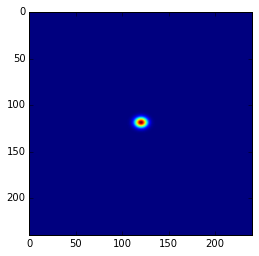

In [310]:
# artificially reduced amplitude to 80%
pointSource_excess = TwoD_Gaussian(coords, p_opt[0], p_opt[1], p_opt[2], p_opt[3], p_opt[4], p_opt[5])
residual_skymap = excess_data_N - pointSource_excess.reshape(240,240)
#print(residual_skymap[115:125,115:125])
fig_PS = pyplot.figure()
pyplot.imshow(pointSource_excess.reshape(240,240))

<h2> Plotting the fit of Sgr A*

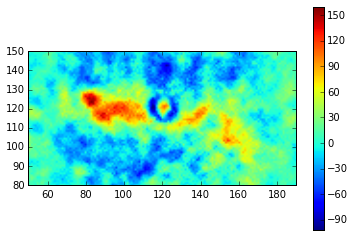

In [311]:
#fig_residual = pyplot.figure(figsize=(8,8))
fig_residual = pyplot.figure()
pyplot.axis([50,190,80,150])
pyplot.imshow(residual_skymap)

cbar = pyplot.colorbar()
cbar.solids.set_edgecolors('face')

#fig_residual.set_axes

In [312]:
init_guess_2 = (500,120,121,1,1,50)
p_opt, p_cov = optimize.curve_fit(TwoD_Gaussian, coords, residual_skymap.ravel(), p0=init_guess_2)
print(p_opt)


[  1.29518928e+02   1.20706454e+02   1.20512236e+02   1.41213684e+00
   1.81193481e+00  -3.61472250e-02]


In [313]:
pointSource_excess_2 = TwoD_Gaussian(coords, 0.8*p_opt[0], p_opt[1], p_opt[2], p_opt[3], p_opt[4], p_opt[5])
residual_skymap_2 = residual_skymap - pointSource_excess_2.reshape(240,240)
print(residual_skymap_2[115:125,115:125])

[[  12.86652176    5.01904166  -34.73422587  -59.67530659  -47.29054251
     0.23774126  -16.95113244  -31.70145696  -43.21640837  -51.51575214]
 [ -22.7869066   -50.47455318  -50.96060837  -63.17005953  -10.01231516
    28.78380595   -5.83328477  -29.15134546  -53.1870601   -78.16341482]
 [ -52.1160755   -51.98149184  -54.60815017  -14.70047417    2.84600274
    34.08692222   22.82251723  -14.80252578  -51.92777685  -58.24176886]
 [ -77.64735263  -75.24385803  -48.5191522    -8.9150909    26.47256842
    42.67945336   29.4260326     2.76522458  -23.35176385  -52.13353415]
 [ -88.01441137  -85.81208051  -21.62307575   -9.76988296   12.92524639
    12.87720441   10.72327887    1.89110479    7.58531271   -8.35379955]
 [-101.95933229  -87.11455218  -31.05139793   29.4531592    33.81250818
     3.2603926     5.03910389   18.16715207   34.61631847   11.9052671 ]
 [-101.78616093  -84.54745115  -18.1961482    32.60638722   21.94125273
     5.9051794    11.65682728   35.8116862    58.5910697  

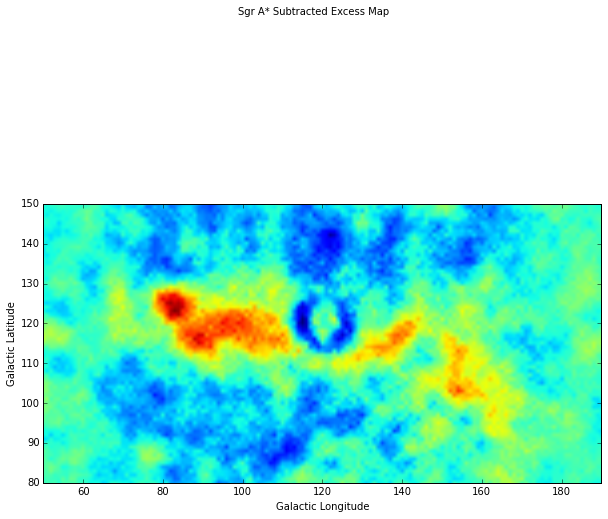

In [314]:
fig_residual_2 = pyplot.figure(figsize=(10,10))
fig_residual_2.suptitle("Sgr A* Subtracted Excess Map")
ax = fig_residual_2.add_subplot(1,1,1)
ax.set_xlabel("Galactic Longitude")
ax.set_ylabel("Galactic Latitude")
pyplot.axis([50,190,80,150])
pyplot.imshow(residual_skymap_2)
#cbar = pyplot.colorbar()
#cbar.solids.set_edgecolors('face')


<h2>FITS figure of partially subtracted map

In [319]:
outFilename = "./subtracted_skymap_2.fits"
subtracted_header = skymap_header.copy()

fits.writeto(outFilename, residual_skymap_2, subtracted_header, clobber=True)

INFO:astropy:Auto-setting vmin to -6.780e+01
INFO:astropy:Auto-setting vmax to  1.218e+02


INFO: Auto-setting vmin to -6.780e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.218e+02 [aplpy.core]


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


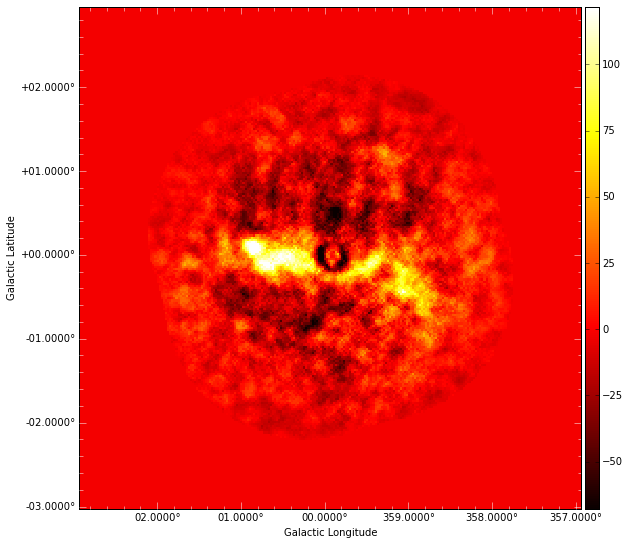

In [320]:
fig_apl = aplpy.FITSFigure(outFilename)
fig_apl.show_colorscale(cmap='hot')
col_bar = fig_apl.show_colorbar()
#col_bar

In [317]:
# grids for world coordinates, mesh 
x_world, y_world = fig_apl.pixel2world(x,y)
coords_world = x_world, y_world

init_guess_G0901 = (250,0.87,0.08,.3,.3,1)

p_opt_G0901, p_cov_G0901 = optimize.curve_fit(TwoD_Gaussian, coords_world, residual_skymap.ravel(), p0=init_guess_G0901)
print(p_opt_G0901)

[  1.30102578e+02   6.29651905e-01  -5.58079348e-02   3.09792699e-01
   1.47317093e-01  -1.01363319e+00]


In [318]:
print(fig_apl.world2pixel(.87,.08))
#excess_data_N[81:85,123:127]

(82.965071714460734, 125.04094076750306)
